In [1]:
#To do
#SNR function --- DID SSE instead
#work with the music
#learn on clean half, denoise distorted half
#learn on distorted all, denoise all

#learn dictionary on non-noise Duet Chorus 176-210s solo_acapella.wav


In [2]:
from os import stat
import sys
import scipy
import numpy as np
import matplotlib.pyplot as plt
import wave
import soundfile as sf
import math
from time import time

from sklearn.decomposition import DictionaryLearning
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn.externals import joblib
 
from playsound import playsound
from scipy.io import wavfile

In [3]:
def plotFile(filename):
    #credit to http://gree2.github.io/python/2015/04/14/python-code-read-wave-file-and-plot
    wav_file = wave.open(filename,'rb')
    params = wav_file.getparams()
    
    nchannels, sampwidth, framerate, nframes = params[:4]

    str_data = wav_file.readframes(nframes)
    wav_file.close()
    
    wave_data = np.frombuffer(str_data, dtype=np.short)
    wave_data.shape = -1,2
    wave_data = wave_data.T
    time = np.arange(0,nframes)*(1.0/framerate)

    titlech1 = filename + ' channel 1'
    titlech2 = filename + ' channel 2'
    
    duration = nframes/float(framerate)
    xticks = np.arange(0, duration, 10)
    plt.figure(figsize=(12,6))
    plt.subplot(211).set_xticks(xticks)
    plt.plot(time, wave_data[0])
    plt.title(titlech1, loc='left')
    
    plt.subplot(212).set_xticks(xticks)
    plt.plot(time, wave_data[1], c="g")
    plt.xlabel("time (seconds)")
    plt.title(titlech2, loc='left')
    plt.show()
    
    #playsound(filename)
    return

In [4]:
def compareFiles(denoised,distorted,clean,title):
    
    print('-------------------')
    print('-------------------')
    print(title)
    s = SSE(denoised,clean)
    print('SSE (norm: %.2f)' % s)
    print('denoised file')
    file = title + '.wav'
    sf.write(file,denoised,samplerate)
    plotFile(file)
    
    print('distorted file')
    plotFile('distorted.wav')
    
    print('clean original')
    plotFile('clean_2')
    
    return
    

In [5]:
#signal will be distorted by a white noise and crackle
#wf is the white noise factor (0.005 is a good start)
#cf is the crackle noise factor (1000)
def distort(signal):#,wf,cf):
    height, width = signal.shape
    #add white noise
    signal += 0.005 * np.random.randn(height, width)
    
    #add crackle noise
    for s in range(0,height):
        for c in range(0,width):
            if (np.random.randint(1, 1000) == 1):
                signal[s][c] = 2.0*np.random.random() - 1.0
                
    return signal

In [6]:
#We need an element wise measure of the prediction 
#SSE provides a decent measure of the spread of errors
def SSE(predicted, truth):
    sse = 0
    pred = predicted.ravel()
    t = truth.ravel()
    for i, p in enumerate(pred):
        sse += math.pow((t[i] - p),2)
    print(sse)
    return

In [7]:
def SNR(signal, noise):
    #SNR is the ratio of signal and noise strength
    samples = signal.shape[0]*signal.shape[1]
    if signal.shape != noise.shape:
        print('error, signal and noise should be same size')
        return
    
    #strength of a signal we measure the mean square value of the signal
    s_str = 0.0
    r_signal = signal.ravel()
    r_noise = noise.ravel()
    for s in r_signal:
        s_str += s*s
    s_str = s_str / samples
    #print(s_str)
    n_str = 0.0
    for n in r_noise:
        n_str += n*n
    n_str = n_str / samples
    #print(n_str)
    return s_str / n_str

In [8]:
def learnDictionaryMini(learn,name,n_comp,algo,batch_size):
    t0 = time()
    ###pre-process sample from which to learn
    #Extract patches
    patch_size = (100,2) #both channels together
    patches = extract_patches_2d(learn,patch_size)
    patches = patches.reshape(patches.shape[0], -1)
    #normalize patches
    patches -= np.mean(patches, axis=0)
    patches /= np.std(patches, axis=0)
    
    #Learn dictionary
    print('learning the dictionary, %d components, using %s with batch size 0f %s' % (n_comp, algo,batch_size))
    #dictionary = DictionaryLearning(n_components=n_comp,fit_algorithm=algo, alpha=1, n_jobs=-1)
    dictionary = MiniBatchDictionaryLearning(n_components=n_comp,fit_algorithm=algo,batch_size=batch_size, alpha=1, n_jobs=-1)
    model = dictionary.fit(patches)
    print('finished learning dictionary')
    
    #Save the model
    file_name = name + '-' + str(n_comp) + '-' + algo + '-' + str(batch_size) + '.sav'
    joblib.dump(model,file_name)
    
    print('done in %.2fs' % (time() - t0))
    print('saving the file to ' + file_name)
    return model

In [29]:
def learnDictionary(learn,name,n_comp,algo):
    t0 = time()
    ###pre-process sample from which to learn
    #Extract patches
    patch_size = (100,2) #both channels together
    patches = extract_patches_2d(learn,patch_size)
    patches = patches.reshape(patches.shape[0], -1)
    #normalize patches
    patches -= np.mean(patches, axis=0)
    patches /= np.std(patches, axis=0)
    
    #Learn dictionary
    print('learning the dictionary, %d components, using %s with full data set' % (n_comp, algo))
    dictionary = DictionaryLearning(n_components=n_comp,fit_algorithm=algo, alpha=1, n_jobs=-1, max_iter=5000)
    model = dictionary.fit(patches)
    print('finished learning dictionary')
    
    #Save the model
    file_name = name + '-' + str(n_comp) + '-' + algo + '-' + '.sav'
    joblib.dump(model,file_name)
    
    print('done in %.2fs' % (time() - t0))
    print('saving the file to ' + file_name)
    return model

In [10]:
def testSplit(test_set):
    #split test_set into 10 second clips
    split = np.array_split(test_set,int((test_set.shape[0] / samplerate ) / 10))
    
    return split

In [11]:
filename='D:\Documents-data\Advanced Data Analytics\Group Project\Dictionary_Learning_Tests\solo_acapella.wav'
#filename='music-denoising-project\input\Ring01.wav'

In [12]:
data, samplerate = sf.read(filename) #Sound file returns float64 encoding

In [13]:
#plotFile(filename)

In [14]:
#for solo_acapella train is the last chorus that includes both voices
start = 176 #in seconds
fin = 212 #in seconds
train = data[start*samplerate:fin*samplerate]
#sf.write('solo_train.wav',train,samplerate)
#plotFile('solo_train.wav')

In [15]:
a = 3

In [16]:
del a

In [17]:
a

NameError: name 'a' is not defined

In [27]:
model = learnDictionaryMini(train,'solo_acapella_176-212',500,'cd',1000)

learning the dictionary, 500 components, using cd with batch size 0f 1000


C:\Python3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


finished learning dictionary
done in 2451.57s
saving the file to solo_acapella_176-212-500-cd-1000.sav


In [28]:
del model

In [30]:
model = learnDictionaryMini(train,'solo_acapella_176-212_again',500,'cd',1000)

learning the dictionary, 500 components, using cd with batch size 0f 1000


C:\Python3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


finished learning dictionary
done in 2469.71s
saving the file to solo_acapella_176-212_again-500-cd-1000.sav


In [ ]:
del model

In [ ]:
model = learnDictionary(train,'solo_acapella_176-212d',500,'lars')

In [14]:
#test_set is the rest of the song clipped together
#we split it into seperate 10s intervals for testing
#for solo_acapella, it removes the last chorus that we train on
first = data[0:start*samplerate]
second = data[fin*samplerate:]
test_set = np.concatenate((first,second))
#sf.write('solo_test.wav',test_set,samplerate)
#plotFile('solo_test.wav')

In [16]:
tests = testSplit(test_set)

In [17]:
#model = learnDictionary(train,'solo_acapella_176-212',100,'cd')
#model = joblib.load('solo_acapella_176-212.sav')

In [18]:
tests[0]

array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 6.10351562e-05],
       [0.00000000e+00, 9.15527344e-05],
       [0.00000000e+00, 6.10351562e-05]])

In [19]:
model.set_params(transform_algorithm='omp',transform_n_nonzero_coefs=16)
t0 = time()
snr_before_mean = 0.0
snr_before_stdev = []
snr_after_mean = 0.0
snr_after_stdev = []
for i,test in enumerate(tests):
    print('performing test segment %d' %i)
    c = test.copy()
    t = test.copy()
    t = distort(t)
    n = t - c
    snr_before = SNR(c,n) 
    snr_before_mean += snr_before
    snr_before_stdev.append(snr_before)
    cl = 'clean' + str(i) + '.wav'
    sf.write(cl,c,samplerate)
    dist = 'distorted' + str(i) + '.wav'
    sf.write(dist,t,samplerate)
    print('\tSNR before denoise = %.3f' % snr_before)
    
    print('\tpre-processing test segment %d' %i)
    #pre-process noisy file
    patch_size = (100,2) #both channels together
    height,width = t.shape
    test_patches = extract_patches_2d(t, patch_size)
    test_patches = test_patches.reshape(test_patches.shape[0],-1)
    #center the data
    intercept = np.mean(test_patches, axis=0)
    test_patches -= intercept
    
    print('\tlearning the sparse code for test %d' %i)
    t1 = time()
    code = model.transform(test_patches) #this is sparse code
    
    print('\trestoring test segment %d' %i)
    #reconstruct the patches from the dot product of the sparse code and dictionary
    recon_patches = np.dot(code, model.components_)
    #uncenter the reconstructed data
    recon_patches += intercept
    #unstack the reconstructed patches
    recon_patches = recon_patches.reshape(len(recon_patches), *patch_size)
    restored = reconstruct_from_patches_2d(recon_patches, (height,width))
    name = 'segment' + str(i) + '.wav'
    sf.write(name,restored,samplerate)
    n_after = c - restored
    snr_after = SNR(c,n_after)
    snr_after_mean += snr_after
    snr_after_stdev.append(snr_after)
    print('\ttest %d done with SNR of %.3f completed in %.2fs' % (i, snr_after, time() - t1))
    
snr_before_mean = snr_before_mean / len(tests)
snr_b_stdev = 0.0
for x in snr_before_stdev:
    snr_b_stdev += math.pow((x - snr_before_mean),2)
snr_b_stdev = math.sqrt(snr_b_stdev / len(snr_before_stdev))

snr_after_mean = snr_after_mean / len(tests)
snr_a_stdev = 0.0
for x in snr_after_stdev:
    snr_a_stdev += math.pow((x - snr_after_mean),2)
snr_a_stdev = math.sqrt(snr_a_stdev / len(snr_after_stdev))

print('TEST COMPLETE in %.2fs\nMean SNR before denoising %.3f\tStd Dev %.3f\nMean SNR after denoising %.3f\tStd Dev %.3f' % ((time()-t0),snr_before_mean, snr_b_stdev,snr_after_mean, snr_a_stdev))

performing test segment 0
2.5937137574848315e-09
0.0003574986449917389
	SNR before denoise = 0.000
	pre-processing test segment 0
	learning the sparse code for test 0
	restoring test segment 0
2.5937137574848315e-09
4.16052306594372e-05
	test 0 done with SNR of 0.000 completed in 350.87s
performing test segment 1
0.007618802999146967
0.000397656818635589
	SNR before denoise = 19.159
	pre-processing test segment 1
	learning the sparse code for test 1
	restoring test segment 1
0.007618802999146967
0.00022304152068556305
	test 1 done with SNR of 34.159 completed in 343.97s
performing test segment 2
0.011122211087601702
0.0003890853288915639
	SNR before denoise = 28.586
	pre-processing test segment 2
	learning the sparse code for test 2
	restoring test segment 2
0.011122211087601702
0.0002143847767931376
	test 2 done with SNR of 51.880 completed in 341.37s
performing test segment 3
0.009468795585850448
0.00034260683653251765
	SNR before denoise = 27.637
	pre-processing test segment 3
	lear

TypeError: unsupported operand type(s) for -: 'float' and 'builtin_function_or_method'

In [36]:
#model = learnDictionary(train,'solo_acapella_176-212',100,'cd')
#learnDictionary(train,'solo_acapella_176-212',500,'lars',100)
#learnDictionary(train,'solo_acapella_176-212',500,'lars',1000)

learning the dictionary, 500 components, using lars with batch size 0f 1000
finished learning dictionary
done in 4710.78s
saving the file to solo_acapella_176-212-500-lars-1000.sav


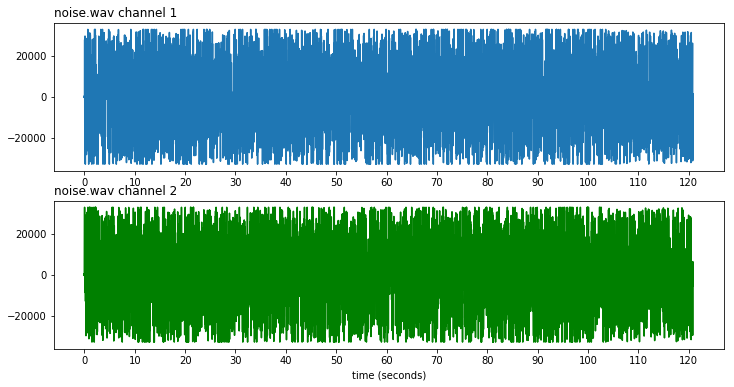

In [15]:
noise = clean_2 - distorted
sf.write('noise.wav',noise,samplerate)
plotFile('noise.wav')

In [16]:
SSE(distorted,clean_2)

4021.948660704602


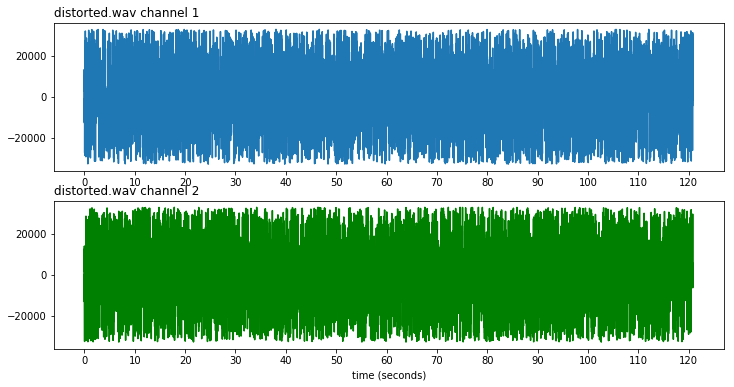

In [17]:
sf.write('distorted.wav',distorted,samplerate)
plotFile('distorted.wav')

In [18]:
#Extract patches from first half of song, clean_1
patch_size = (100,2) #both channels together
patches = extract_patches_2d(clean_1,patch_size)
patches = patches.reshape(patches.shape[0], -1)

#normalize patches so we can learn the dictionary
patches -= np.mean(patches, axis=0)
patches /= np.std(patches, axis=0)

In [19]:
patches.shape

(5330929, 200)

In [23]:
#Learn dictionary
t0 = time()
dictionary = MiniBatchDictionaryLearning(n_components=100, alpha=1, n_jobs=-1)
V = dictionary.fit(patches).components_ 
print('done in %.2fs' % (time() - t0))

done in 602.83s


In [24]:
#pre-process noisy file
distorted_patches = extract_patches_2d(distorted, patch_size)
distorted_patches = distorted_patches.reshape(distorted_patches.shape[0],-1)

#center the data
intercept = np.mean(distorted_patches, axis=0)
distorted_patches -= intercept

In [28]:
transform_algorithms = [
    ('lasso_lars alpha=.001', 'lasso_lars', {'transform_alpha': 0.001}),
    ('lasso_lars alpha=.01', 'lasso_lars', {'transform_alpha': 0.01}),
    ('lasso_lars alpha=.1', 'lasso_lars', {'transform_alpha': 0.1}),
    ('lasso_lars alpha=1', 'lasso_lars', {'transform_alpha': 1}),
    ('lasso_cd alpha=.001', 'lasso_cd', {'transform_alpha': .001}),
    ('lasso_cd alpha=.01', 'lasso_cd', {'transform_alpha': .01}),
    ('lasso_cd alpha=.1', 'lasso_cd', {'transform_alpha': .1}),
    ('lasso_cd alpha=1', 'lasso_cd', {'transform_alpha': 1}),
    ('threshold alpha=.001', 'threshold', {'transform_alpha': .001}),
    ('threshold alpha=.01', 'threshold', {'transform_alpha': .01}),
    ('threshold alpha=.1', 'threshold', {'transform_alpha': .1}),
    ('threshold alpha=1', 'threshold', {'transform_alpha': 1}),
    ('lars 2 atom', 'lars', {'transform_n_nonzero_coefs': 2}),
    ('lars 20 atom', 'lars', {'transform_n_nonzero_coefs': 20}),
    ('lars 40 atom', 'lars', {'transform_n_nonzero_coefs': 40}),
    ('omp 2 atoms', 'omp', {'transform_n_nonzero_coefs': 2}),
    ('omp 16 atoms', 'omp', {'transform_n_nonzero_coefs': 16}),
    ('omp 32 atoms', 'omp', {'transform_n_nonzero_coefs': 32})
]

In [29]:
comm="""transform_algorithms = [
    ('omp 16 atoms', 'omp', {'transform_n_nonzero_coefs': 16})
]"""

In [31]:
#for loop on the transform_algorithms to compare all these against the task
#need a print function so we can see them side by side
#need a measure to compare by
reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    t0 = time
    print(title + '...')
    reconstructions[title] = distorted.copy()
    dictionary.set_params(transform_algorithm=transform_algorithm,**kwargs)
    code = dictionary.transform(distorted_patches) #this is sparse code
    #reconstruct the patches from the dot product of the sparse code and dictionary
    recon_patches = np.dot(code, V)
    #uncenter the reconstructed data
    recon_patches += intercept
    #unstack the reconstructed patches
    recon_patches = recon_patches.reshape(len(distorted_patches), *patch_size)
    #Threshold isn't working for some reason
    #if transform_algorithm == 'threshold':
    #    recon_patches -= recon_patches.min()
    #    recon_patches /= recon_patches.max()
    reconstructions[title] = reconstruct_from_patches_2d(recon_patches, (height,width))
    #compareFiles(reconstructions[title],clean_data,title)
    s = SSE(distorted, clean_2)
    compareFiles(reconstructions[title],distorted,clean_2,title)
    print('done in %.2fs' % (time() - t0))
    

lasso_lars alpha=.001...


KeyboardInterrupt: 